# **1. 준비된 Custom Dataset 가져오기**

**1-1. 데이터 가져오기**
- VM에 dataset.zip 파일로 업로드 후 압축 풀기

In [ ]:
import zipfile

with zipfile.ZipFile('/content/dataset1.zip') as target_file:
    target_file.extractall('/content/dataset')

**1-2. 데이터 분할 및 학습할 폴더 구조 갖추기**

In [ ]:
import os
import shutil

current_path = os.path.abspath(os.curdir)
data_path = current_path + '/dataset'

test_percentage = 0.2  # test dataset percentage
val_percentage = 0   # val dataset percentage

image_paths = []
label_paths = []

# 데이터 분할
os.chdir(data_path)
for current_dir, dirs, files in os.walk('.'):
    for f in files:
        if f.endswith('.jpg'):
            image_path = current_path + '/dataset/' + f
            image_paths.append(image_path)
            fn = f.split('.')
            label_path = current_path + '/dataset/' + fn[0] + '.txt'
            label_paths.append(label_path)

# test dataset
image_paths_test = image_paths[:int(len(image_paths) * test_percentage)]
label_paths_test = label_paths[:int(len(label_paths) * test_percentage)]

# train dataset
image_paths = image_paths[int(len(image_paths) * test_percentage):]
label_paths = label_paths[int(len(label_paths) * test_percentage):]

# train dataset에서 다시 val dataset으로 분할
image_paths_val = image_paths[:int(len(image_paths) * val_percentage)]
label_paths_val = label_paths[:int(len(label_paths) * val_percentage)]

# 최종적인 train dataset
image_paths_train = image_paths[int(len(image_paths) * val_percentage):]
label_paths_train = label_paths[int(len(label_paths) * val_percentage):]

# train dataset 준비
if not os.path.exists('/content/train'):
  os.makedirs('/content/train/images')
  os.makedirs('/content/train/labels')

  for _source in image_paths_train:
    shutil.copy(_source, '/content/train/images')

  for _source in label_paths_train:
    shutil.copy(_source, '/content/train/labels')

# val dataset 준비
if not os.path.exists('/content/val'):
  os.makedirs('/content/val/images')
  os.makedirs('/content/val/labels')

  for _source in image_paths_val:
    shutil.copy(_source, '/content/val/images')

  for _source in label_paths_val:
    shutil.copy(_source, '/content/val/labels')

# test dataset 준비
if not os.path.exists('/content/test'):
  os.makedirs('/content/test/images')
  os.makedirs('/content/test/labels')

  for _source in image_paths_test:
    shutil.copy(_source, '/content/test/images')

  for _source in label_paths_test:
    shutil.copy(_source, '/content/test/labels')

# 작업 디렉토리를 다시 /content 로 변경
os.chdir('/content')

# **1-2. 준비된 Custom Dataset 가져오기(from roboflow.com)**

In [ ]:
!curl -L "https://app.roboflow.com/ds/5gzAoxt29G?key=IPMfpJbGQE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   1613      0 --:--:-- --:--:-- --:--:--  1610
100 2420k  100 2420k    0     0   869k      0  0:00:02  0:00:02 --:--:-- 2188k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/fruit09_jpg.rf.e8b66ab955d8f5d3220948c983025116.jpg  
 extracting: test/images/fruit20_jpg.rf.7c78960af7111973a712336df2364966.jpg  
   creating: test/labels/
 extracting: test/labels/fruit09_jpg.rf.e8b66ab955d8f5d3220948c983025116.txt  
 extracting: test/labels/fruit20_jpg.rf.7c78960af7111973a712336df2364966.txt  
   creating: train/
   creating: train/images/
 extracting: train/images/fruit01_jpg.rf.08c43930f9ded7a063335405059def90.jpg  
 extracting: train/images/fruit01

**roboflow 에서 제공해준 yaml파일 확인해 보자.**

In [ ]:
!cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['Apple', 'Oriental melon', 'Tomato']

roboflow:
  workspace: jhsongok
  project: fruit_detection-ngi40
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/jhsongok/fruit_detection-ngi40/dataset/1

# **2. Custom yaml 파일을 만들자.**

In [ ]:
# PyYAML을 설치하자
!pip install PyYAML

In [ ]:
import yaml

data_cf = {'train' : '/content/train/images',
           'val' : '/content/test/images',
           'names' : ['Oriental melon', 'Tomato', 'Apple'],
           'nc' : 3 }

# fruit_data.yaml 이란 이름으로 custom yaml 파일을 만든다.
with open('/content/fruit_data.yaml', 'w') as f:
  yaml.dump(data_cf, f)

# fruit_data.yaml 확인
with open('/content/fruit_data.yaml', 'r') as f:
  fruit_yaml = yaml.safe_load(f)
  display(fruit_yaml)

{'names': ['Oriental melon', 'Tomato', 'Apple'],
 'nc': 3,
 'train': '/content/train/images',
 'val': '/content/test/images'}

# **3. YOLOv8을 사용하기 위한 Setup(셋업)**

In [ ]:
# ultralytics 설치
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.0/800.0 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
# ultralytics 를 불러오고 체크
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.3/78.2 GB disk)


# **4. Custom YOLO Training(학습)**

**Detection 모델로 사용할 수 있는 모델의 종류**

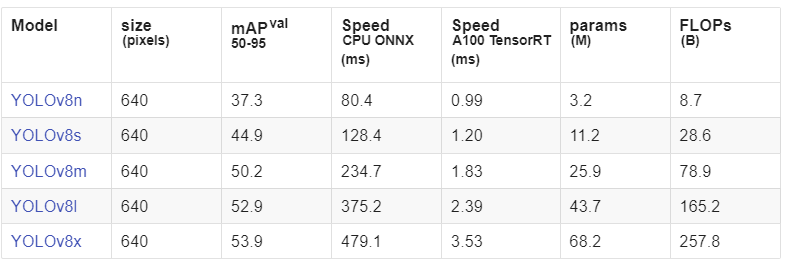

In [ ]:
# ultralytics에서 YOLO 모듈을 불러옴
from ultralytics import YOLO
# yolov8n.pt 모델의 아키텍처와 가중치을 함께 불러옴
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 107MB/s]


In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

**불러온 모델 아키텍처를 이용하여 우리가 준비한 Custom Dataset으로 학습을 시켜보자.**

In [ ]:
model.train(data='/content/fruit_data.yaml', epochs=100, patience=5, batch=8, imgsz=640)

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/fruit_data.yaml, epochs=100, time=None, patience=5, batch=8, imgsz=1440, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 22.5MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 255.08it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/test/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 125.64it/s]

val: New cache created: /content/test/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1440 train, 1440 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
      1/100      5.89G     0.4861      3.157      1.015         80       1440: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all          4         14     0.0218          1      0.254      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.44G     0.4408      3.149      0.967         93       1440: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all          4         14     0.0217          1      0.259      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.02G     0.4295      3.089     0.9819         82       1440: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          4         14     0.0172          1      0.406      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.84G     0.4256      2.942      0.984         53       1440: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all          4         14     0.0138          1      0.431      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.85G     0.3451      2.696      0.901        115       1440: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all          4         14     0.0122          1       0.47      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.57G     0.4246      2.457     0.9622         98       1440: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all          4         14      0.012          1      0.569      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       5.8G     0.4835      2.377      1.046         67       1440: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all          4         14     0.0123          1      0.627      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.81G     0.4006       2.12     0.9571         79       1440: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all          4         14     0.0138          1      0.671       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.64G     0.4209      1.972     0.9632         63       1440: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          4         14     0.0161          1      0.667      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       5.6G     0.3842      1.795     0.9408         99       1440: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all          4         14       0.34          1      0.759      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.63G      0.395      1.657     0.9138        115       1440: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          4         14      0.884      0.535      0.821      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.26G     0.3617       1.35     0.8793        112       1440: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all          4         14      0.884      0.535      0.821      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.61G     0.4366      1.506     0.9693         62       1440: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all          4         14          1      0.552      0.884       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       5.8G     0.3408      1.172     0.8873         91       1440: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all          4         14          1      0.783      0.962      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.82G     0.3867      1.165     0.9151         69       1440: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          4         14          1      0.783      0.962      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.64G     0.3656      1.065     0.8951         80       1440: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all          4         14      0.998      0.864      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.65G     0.3482      0.984     0.8534         98       1440: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          4         14      0.999      0.832      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       5.6G     0.3278      1.284     0.8677         68       1440: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all          4         14      0.999      0.832      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.64G     0.3291     0.9348     0.8281         77       1440: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all          4         14      0.941      0.932      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.85G     0.3951      1.005     0.9527        106       1440: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          4         14      0.941      0.932      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.65G     0.3857      1.002     0.9432         82       1440: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

                   all          4         14      0.926          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       5.6G     0.3372     0.9747     0.8585         69       1440: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all          4         14      0.926          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.83G     0.3972      1.258     0.9603         73       1440: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all          4         14      0.927      0.953      0.995      0.966
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 18, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



23 epochs completed in 0.017 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


                   all          4         14          1      0.831      0.995       0.97
        Oriental melon          3          4          1      0.701      0.995      0.995
                Tomato          3          5          1      0.794      0.995       0.94
                 Apple          4          5          1          1      0.995      0.975
Speed: 0.8ms preprocess, 6.7ms inference, 0.0ms loss, 16.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c10458e8670>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# **5. Training(학습) 결과 확인**

**학습 결과를 그래프로 저장한 파일을 통해 확인해 본다**

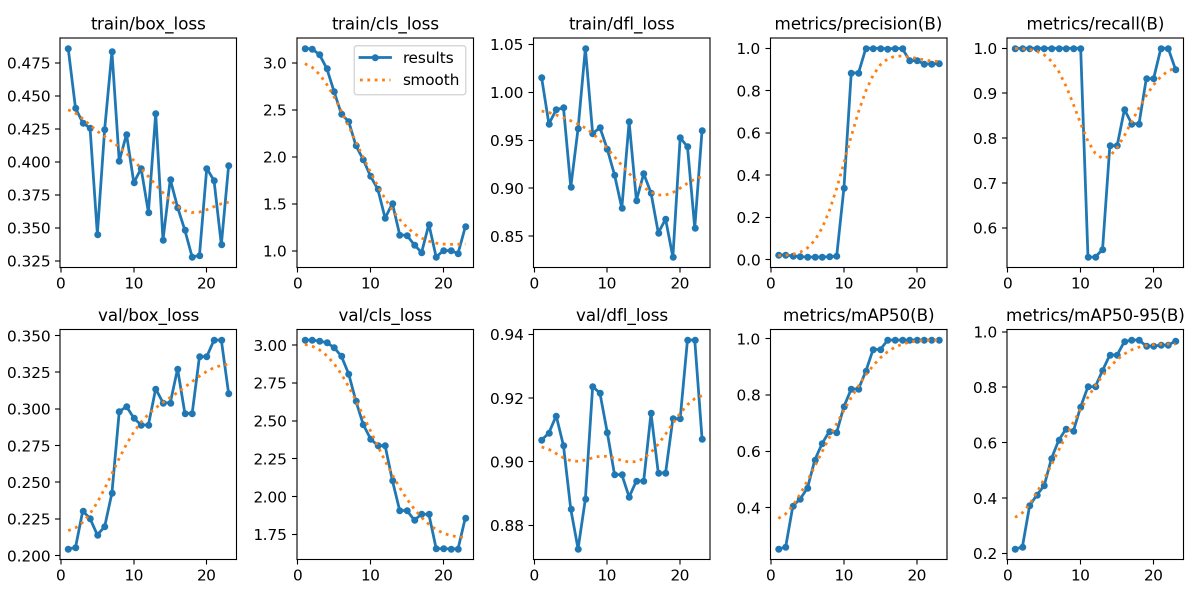

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

result_img = cv2.imread('/content/runs/detect/train/results.png')
fix_width = 1200
height,width = result_img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
result_img = cv2.resize(result_img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(result_img)

**Custom 모델이 분류할 수 있는 부류 확인**

In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 3
{0: 'Oriental melon', 1: 'Tomato', 2: 'Apple'}


# **6. Custom 모델로 Detection(검출)**

**Image Detection**

In [ ]:
# 모델 예측
results = model.predict(source='/content/test/images/fruit11.jpg', save=True)


image 1/1 /content/test/images/fruit11.jpg: 1088x1440 1 Tomato, 1 Apple, 155.3ms
Speed: 6.0ms preprocess, 155.3ms inference, 2.6ms postprocess per image at shape (1, 3, 1088, 1440)
Results saved to runs/detect/train2


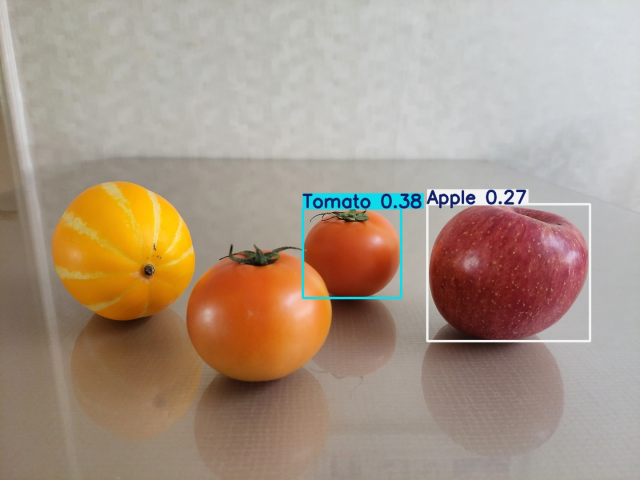

In [ ]:
# 예측 이미지 확인
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/runs/detect/train2/fruit11.jpg')
fix_width = 640
height,width = img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
img = cv2.resize(img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(img)

**Video Detection**

In [ ]:
# 동영상 예측
results = model.predict(source='/content/fruit.mp4', save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/892) /content/fruit.mp4: 832x1440 (no detections), 100.7ms
video 1/1 (frame 2/892) /content/fruit.mp4: 832x1440 (no detections), 15.3ms
video 1/1 (frame 3/892) /content/fruit.mp4: 832x1440 (no detections), 15.6ms
video 1/1 (frame 4/892) /content/fruit.mp4: 832x1440 (no detections), 15.6ms
video 1/1 (frame 5/892) /content/fruit.mp4: 832x1440 (no detections), 15.5ms
video 1/1 (frame 6/892) /content/fruit.mp4: 832x1440 (no detections), 

In [ ]:
# 코랩에서 영상을 보여줄 준비
import io
from IPython.display import HTML
from base64 import b64encode
def show_video(file_name, width=640):
  # show resulting deepsort video
  mp4 = open(file_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width="{0}" controls>
        <source src="{1}" type="video/mp4">
  </video>
  """.format(width, data_url))

In [ ]:
# avi 파일을 mp4 파일로 변환 후 영상을 보여줌
import os
path_video = os.path.join("/content/runs/detect/train3","fruit.avi")
%cd /content/runs/detect/train3
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!ffmpeg -y -loglevel panic -i "fruit.avi" "fruit.mp4"
%cd ../../../

# output object tracking video
path_output = os.path.join("/content/runs/detect/train3","fruit.mp4")
show_video(path_output, width=640)

Output hidden; open in https://colab.research.google.com to view.

# **7. 학습된 모델을 불러와 검출**

In [ ]:
# ultralytics 설치
!pip install ultralytics

# ultralytics 를 불러오고 체크
import ultralytics
ultralytics.checks()

In [ ]:
# ultralytics에서 YOLO 모듈을 불러옴
from ultralytics import YOLO
# 학습된 모델의 아키텍처와 가중치을 함께 불러옴
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 3
{0: 'Oriental melon', 1: 'Tomato', 2: 'Apple'}


In [ ]:
# 모델 예측
results = model.predict(source='/content/test/images/fruit11.jpg', save=True)


image 1/1 /content/test/images/fruit11.jpg: 1088x1440 1 Tomato, 1 Apple, 20.4ms
Speed: 5.9ms preprocess, 20.4ms inference, 2.3ms postprocess per image at shape (1, 3, 1088, 1440)
Results saved to runs/detect/predict


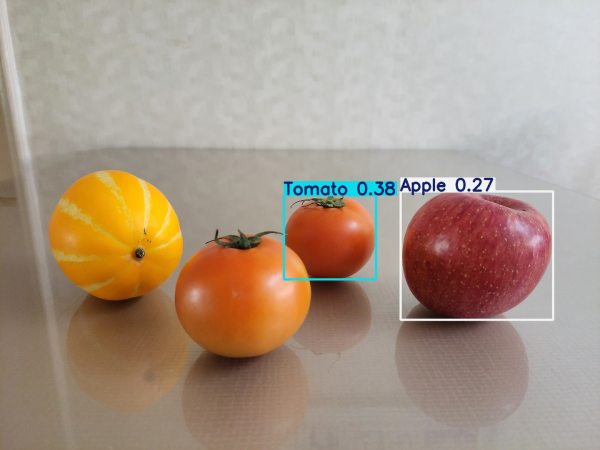

In [ ]:
# 예측 이미지 확인
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/runs/detect/predict/fruit11.jpg')
fix_width = 600
height,width = img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
img = cv2.resize(img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(img)